In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scrapbook as sb

C:\Users\campo\AppData\Local\Continuum\anaconda3\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def vol_ohlc(df, lookback=10):
    # compute volatility from df
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [3]:
def retrieve_data(chosen_token, from_date,to_date):
    # connection to the SQL database at `data.db`
    conn = sqlite3.connect('data.db')
    # create a cursor object from the connection to use for querying:
    cur = conn.cursor()
    cur.execute("SELECT * FROM ohlc WHERE token = (%r) AND ts BETWEEN (%r) AND (%r)"%(chosen_token, from_date,to_date))
    data = cur.fetchall()
    df = pd.DataFrame(
        data,
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD', 'token', 'chain']
    )
    df['hourly_returns(%)'] = (df.close - df.open)/df.open * 100 
    df['volatility'] = vol_ohlc(df)
    df.set_index('ts', inplace=True, drop = True)
    return(df)

In [4]:
# This cell is tagged 'parameters'
chosen_token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'

In [5]:
# Parameters
from_date = "2021-11-26 00:00:00"
to_date = "2021-12-10 00:00:00"
chosen_token = "COMP"


In [6]:
prices = retrieve_data(chosen_token, from_date,to_date)

C:\Users\campo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Hourly max drawdown'}, xlabel='ts'>

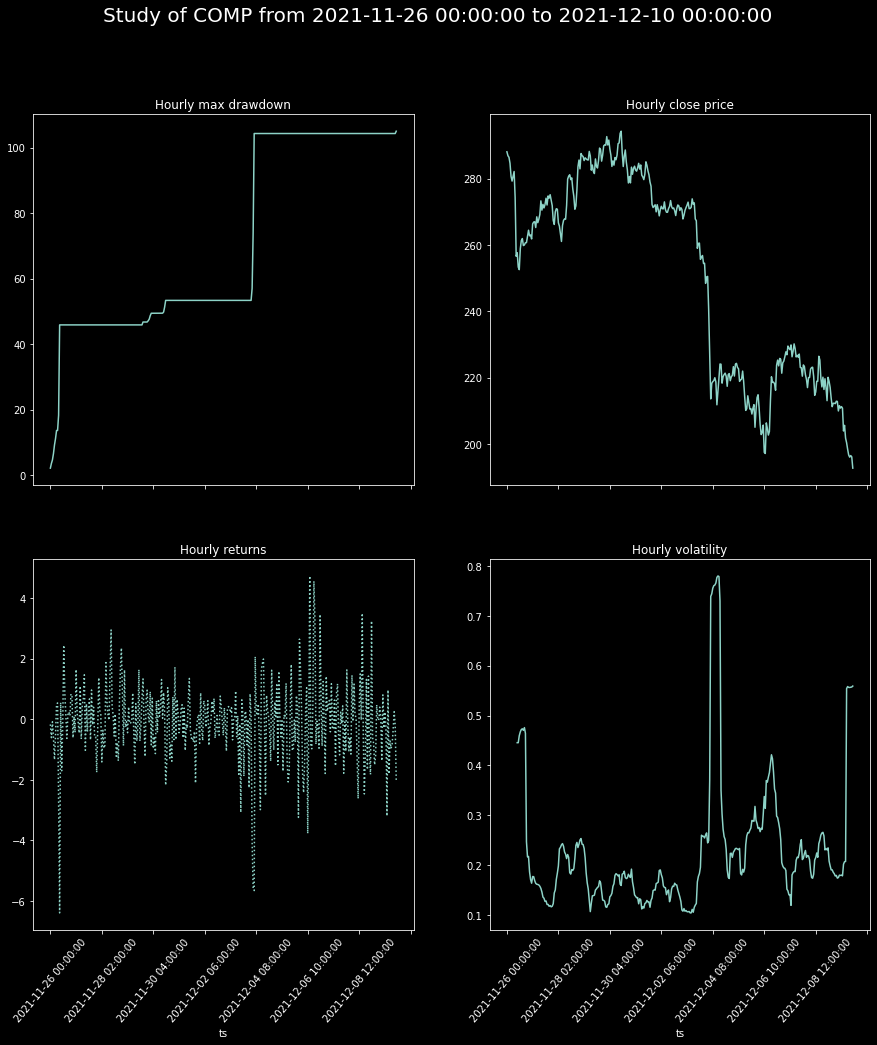

In [7]:
plt.style.use('dark_background')
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(15,15))

fig.suptitle('Study of {} from {} to {}'.format(chosen_token, from_date, to_date), fontsize=20)

prices['hourly_returns(%)'].plot(ax=axs[1,0], title = 'Hourly returns', linestyle = 'dotted', rot = 50)
prices['volatility'].plot(ax=axs[1,1], title = 'Hourly volatility', rot = 50)
prices['close'].plot(ax=axs[0,1], title = 'Hourly close price', rot = 50)
(prices.high.cummax() - prices.low.cummin()).plot(ax=axs[0,0], title = 'Hourly max drawdown', rot = 50)

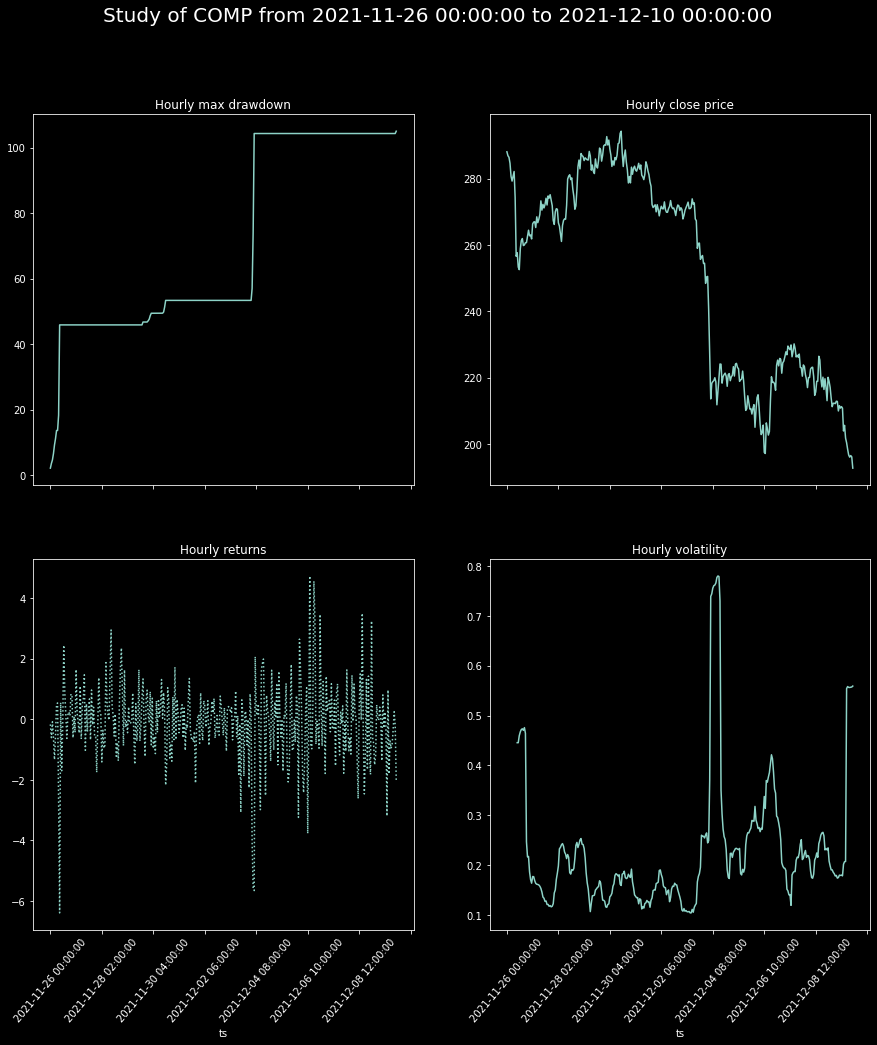

In [8]:
sb.glue('token', chosen_token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)